In [38]:
import scipy as sp
from scipy import linalg 
import pylab as plt


In [39]:
n_snps=10000
n_ind_train=2000
n_ind_ref=1000
n_ind_target=1000

In [151]:
#Simulate LD pattern
rand_signs = sp.sign(sp.randn(n_snps))
conseq_r = rand_signs*sp.sqrt(sp.sqrt(sp.rand(n_snps)))

#Simulating training genotypes
x = sp.zeros((n_snps,n_ind_train))
x[0] = sp.randn(n_ind_train)
for i in range(1,n_snps):
    x[i]=conseq_r[i]*x[i-1]+sp.randn(n_ind_train)*sp.sqrt(1-conseq_r[i]**2)

#Simulating genotypes for LD reference
x_r = sp.zeros((n_snps,n_ind_ref))
x_r[0] = sp.randn(n_ind_ref)
for i in range(1,n_snps):
    x_r[i]=conseq_r[i]*x_r[i-1]+sp.randn(n_ind_ref)*sp.sqrt(1-conseq_r[i]**2)


#Simulating target genotypes 
x_t = sp.zeros((n_snps,n_ind_target))
x_t[0] = sp.randn(n_ind_target)
for i in range(1,n_snps):
    x_t[i]=conseq_r[i]*x_t[i-1]+sp.randn(n_ind_target)*sp.sqrt(1-conseq_r[i]**2)

In [152]:
#Standardized genotypes
#Training data
x = (x.T-sp.mean(x,axis=1)).T
x = (x.T/sp.std(x,axis=1)).T

#LD ref
x_r = (x_r.T-sp.mean(x_r,axis=1)).T
x_r = (x_r.T/sp.std(x_r,axis=1)).T

#Target data
x_t = (x_t.T-sp.mean(x_t,axis=1)).T
x_t = (x_t.T/sp.std(x_t,axis=1)).T


In [153]:
#Calculating training data LD 
xx = x@x.T
D = xx/sp.diag(xx)

#Calculating LD using LD reference
xx = x_r@x_r.T
D_r = xx/sp.diag(xx)

#Calculating target data LD
xx = x_t@x_t.T
D_t = xx/sp.diag(xx)

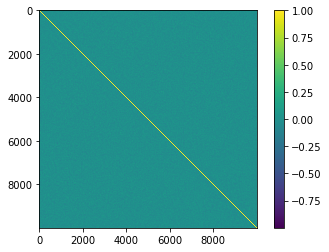

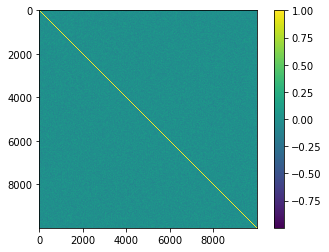

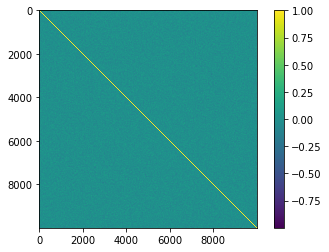

In [154]:
def implot(M, cmap=None):
    plt.imshow(M, cmap=cmap, interpolation='none')
    plt.colorbar()
    plt.show()
implot(D)
implot(D_r)
implot(D_t)

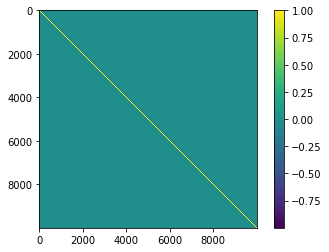

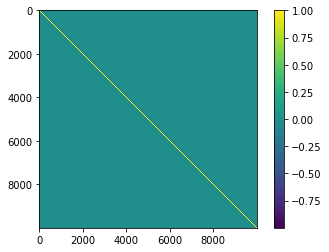

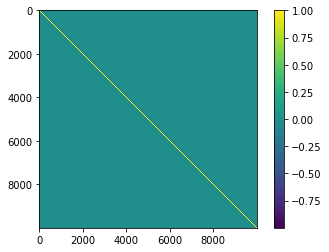

In [155]:
#Banded LD 
w=20
D_mask = sp.zeros((n_snps,n_snps))
D_mask_r = sp.zeros((n_snps,n_snps))
D_mask_t = sp.zeros((n_snps,n_snps))
for i in range(n_snps):
    min_i = max(0,i-w)
    max_i = min(n_snps,i+w)
    D_mask[min_i:max_i,i]=D[min_i:max_i,i]
    D_mask_r[min_i:max_i,i]=D_r[min_i:max_i,i]
    D_mask_t[min_i:max_i,i]=D_t[min_i:max_i,i]

    
implot(D_mask)
implot(D_mask_r)
implot(D_mask_t)

In [156]:
#LD scores
ldsc = sp.diag(D@D)
ldsc_r = sp.diag(D_r@D_r)
ldsc_t = sp.diag(D_t@D_t)

#Banded LD scores
ldsc_mask = sp.diag(D_mask@D_mask)
ldsc_mask_r = sp.diag(D_mask_r@D_mask_r)
ldsc_mask_t = sp.diag(D_mask_t@D_mask_t)


In [197]:
#Simulate phenotypes
def sim_phen(x,x_t,n_phen,prior='laplace'):
    (n_snps,n_ind) =x.shape
    (n_snps_t,n_ind_t) =x_t.shape
    h2 = sp.rand(n_phen,1)
    if prior=='inf':
        betas_true = sp.randn(n_phen,n_snps)
    elif prior=='laplace':
        betas_true = sp.random.laplace(0,1,(n_phen,n_snps))
    elif prior=='sparse':
        betas_true = sp.randn(n_phen,n_snps)  
        betas_true = sp.randn(n_phen,n_snsp)
    else:
        raise Exception()
    
    
    #Training phenotypes
    y_g = betas_true@x
    y_e = sp.randn(n_phen,n_ind)
    y = sp.sqrt(h2) *((y_g.T / sp.std(y_g,axis=1)).T) + sp.sqrt(1-h2)*y_e
    #Standardize phenotypes
    y = ((y.T - sp.mean(y,axis=1))/sp.std(y,axis=1)).T
    
    #Target phenotypes
    y_g = betas_true@x_t
    y_e = sp.randn(n_phen,n_ind_t)
    y_t = sp.sqrt(h2) *((y_g.T / sp.std(y_g,axis=1)).T) + sp.sqrt(1-h2)*y_e
    #Standardize phenotypes
    y_t = ((y_t.T - sp.mean(y_t,axis=1))/sp.std(y_t,axis=1)).T
    
    return {'y': y, 'y_t':y_t, 'betas_true':betas_true.T, 'h2':h2}


In [198]:
sim_phen = sim_phen(x, x_t,n_phen=500)
y = sim_phen['y']
y_t = sim_phen['y_t']
betas_true = sim_phen['betas_true']
h2 = sim_phen['h2']

In [199]:
#Perform GWAS
#train
(n_snps,n_ind) =x.shape
betas = x@y.T/(n_ind)

#target
(n_snps_t,n_ind_t) =x_t.shape
betas_t = x_t@y_t.T/(n_ind_t)

In [200]:
#Perform "p-value" thresholding
betas_thres = betas.copy()
betas_thres[betas**2<0.001]=0


In [201]:
#LDSC regression on GWAS sum stats
def run_ldsc(bs, ldsc, n_ind):
    (n_snps,n_phen) = bs.shape
    x2 = n_ind*(bs*bs).T
    x_var = sp.vstack((sp.ones((n_snps,)),ldsc))
    xx_i = linalg.inv(x_var@x_var.T)
    h2s = sp.zeros(n_phen)
    intercepts = sp.zeros(n_phen)
    for i in range(n_phen):
        w = (xx_i)@x_var@x2[i,]
        intercepts[i] = w[0]
        h2s[i] = n_snps*w[1]/(n_ind)
    return {'intercepts':intercepts, 'h2s':h2s, 'slope':n_ind*(h2s/n_snps)}




In [202]:
#LDSC with full LD
res = run_ldsc(betas, ldsc, n_ind)
print (sp.mean(res['intercepts']))
print (sp.mean(res['h2s']))

#LDSC with masked LD
banded_res = run_ldsc(betas, ldsc_mask, n_ind)
print (sp.mean(banded_res['intercepts']))
print (sp.mean(banded_res['h2s']))
print (sp.mean(banded_res['slope']))


0.4893096502573079
0.5018870256491806
0.9873523007651714
0.5044827828516096
0.10089655657032194


In [203]:
def simp_lin_reg(y, x):
    (n,) = x.shape
    x_var = sp.vstack((sp.ones(n),x))
    xx_i = linalg.inv(x_var@x_var.T)
    w = (xx_i)@x_var@y
    return w


In [204]:
#Overlapping LD reference

# Cs using GWAS betas
c = sp.diag(betas.T @ D @ betas)
c_mask = sp.diag(betas.T @ D_mask @ betas)

# Cs using p-val thresholded GWAS betas
c_thre = sp.diag(betas_thres.T @ D @ betas_thres)
c_mask_thres = sp.diag(betas_thres.T @ D_mask @ betas_thres)

# Cs using true betas
c_true = sp.diag(betas_true.T @ D @ betas_true)
c_mask_true = sp.diag(betas_true.T @ D_mask @ betas_true)



[-8.87474346  2.35502831]


Text(0, 0.5, 'c')

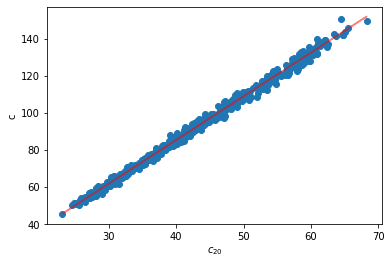

In [205]:
plt.show()
plt.scatter(c_mask,c)
ws = simp_lin_reg(c, c_mask)
print (ws)
plt.plot(c_mask, ws[1]*c_mask + ws[0],color='r',alpha=0.5)
plt.xlabel(r'$c_{20}$')
plt.ylabel(r'c')



[-5.39845286  2.16783307]


Text(0, 0.5, 'c')

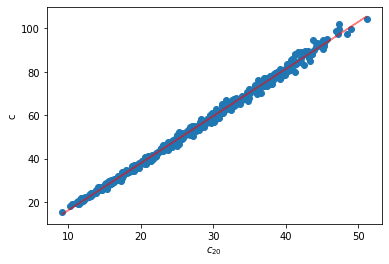

In [206]:
plt.show()
plt.scatter(c_mask_thres,c_thre)
ws = simp_lin_reg(c_thre, c_mask_thres)
print (ws)
plt.plot(c_mask_thres, ws[1]*c_mask_thres + ws[0],color='r',alpha=0.5)
plt.xlabel(r'$c_{20}$')
plt.ylabel(r'c')

[764.37988671   0.96258091]


Text(0, 0.5, 'c')

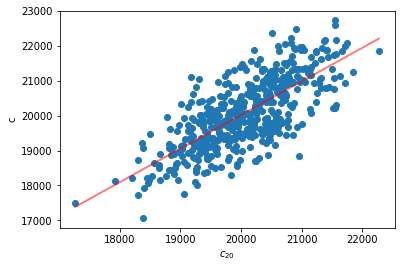

In [207]:
plt.show()
plt.scatter(c_mask_true,c_true)
ws = simp_lin_reg(c_true, c_mask_true)
print (ws)
plt.plot(c_mask_true, ws[1]*c_mask_true + ws[0],color='r',alpha=0.5)
plt.xlabel(r'$c_{20}$')
plt.ylabel(r'c')

In [208]:
#Indep LD reference

# Cs using GWAS betas
c = sp.diag(betas.T @ D_r @ betas)
c_mask = sp.diag(betas.T @ D_mask_r @ betas)

# Cs using p-val thresholded GWAS betas
c_thre = sp.diag(betas_thres.T @ D_r @ betas_thres)
c_mask_thres = sp.diag(betas_thres.T @ D_mask_r @ betas_thres)

# Cs using true betas
c_true = sp.diag(betas_true.T @ D_r @ betas_true)
c_mask_true = sp.diag(betas_true.T @ D_mask_r @ betas_true)

[0.35679844 0.99578761]


Text(0, 0.5, 'c')

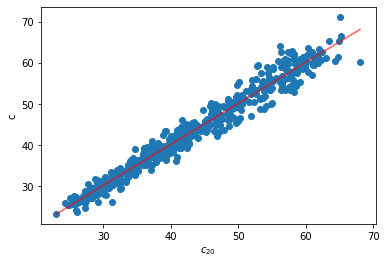

In [209]:
plt.show()
plt.scatter(c_mask,c)
ws = simp_lin_reg(c, c_mask)
print (ws)
plt.plot(c_mask, ws[1]*c_mask + ws[0],color='r',alpha=0.5)
plt.xlabel(r'$c_{20}$')
plt.ylabel(r'c')


[0.15927265 0.99656443]


Text(0, 0.5, 'c')

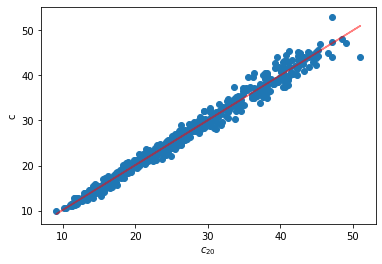

In [210]:
plt.show()
plt.scatter(c_mask_thres,c_thre)
ws = simp_lin_reg(c_thre, c_mask_thres)
print (ws)
plt.plot(c_mask_thres, ws[1]*c_mask_thres + ws[0],color='r',alpha=0.5)
plt.xlabel(r'$c_{20}$')
plt.ylabel(r'c')

[308.12121599   0.98558154]


Text(0, 0.5, 'c')

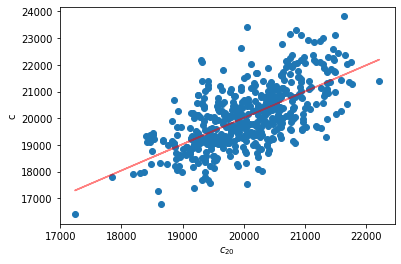

In [211]:
plt.show()
plt.scatter(c_mask_true,c_true)
ws = simp_lin_reg(c_true, c_mask_true)
print (ws)
plt.plot(c_mask_true, ws[1]*c_mask_true + ws[0],color='r',alpha=0.5)
plt.xlabel(r'$c_{20}$')
plt.ylabel(r'c')

In [212]:
#Prediction R2
def eval_pred(betas,betas_t,x_t,D):
    y_p = betas.T@x_t 
    y_p = ((y_p.T - sp.mean(y_p,axis=1))/sp.std(y_p,axis=1)).T

    r2_true = (sp.diag(y_p@y_t.T/n_ind_t)**2)

    c1 = sp.diag(betas.T @ D @ betas)
    r2_est = ((sp.diag(betas.T @ betas_t))**2)/(c1)
    return {'r2_true':r2_true, 'r2_est':r2_est}


[-1.33271389e-03  2.19101464e+00]


Text(0, 0.5, 'True $r^2$')

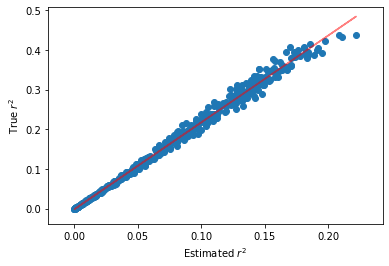

In [213]:
d = eval_pred(betas,betas_t,x_t,D)
r2_est = d['r2_est']
r2_true = d['r2_true']
plt.show()
plt.scatter(r2_est,r2_true)
ws = simp_lin_reg(r2_true, r2_est)
print (ws)
plt.plot(r2_est, ws[1]*r2_est + ws[0],color='r',alpha=0.5)
plt.xlabel(r'Estimated $r^2$')
plt.ylabel(r'True $r^2$')

[0.001022   0.98840984]


Text(0, 0.5, 'True $r^2$')

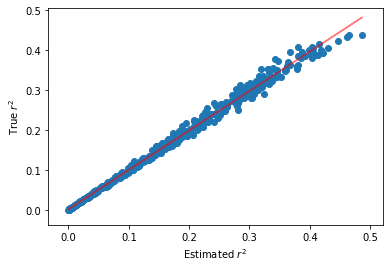

In [214]:
d = eval_pred(betas,betas_t,x_t,D_mask_r)
r2_est = d['r2_est']
r2_true = d['r2_true']
plt.show()
plt.scatter(r2_est,r2_true)
ws = simp_lin_reg(r2_true, r2_est)
print (ws)
plt.plot(r2_est, ws[1]*r2_est + ws[0],color='r',alpha=0.5)
plt.xlabel(r'Estimated $r^2$')
plt.ylabel(r'True $r^2$')

[0.00104657 0.99268026]


Text(0, 0.5, 'True $r^2$')

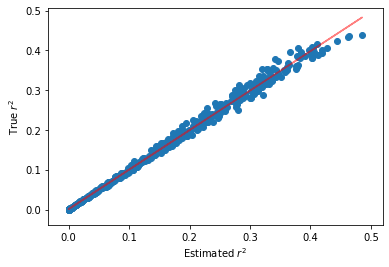

In [215]:
d = eval_pred(betas,betas_t,x_t,D_mask)
r2_est = d['r2_est']
r2_true = d['r2_true']
plt.show()
plt.scatter(r2_est,r2_true)
ws = simp_lin_reg(r2_true, r2_est)
print (ws)
plt.plot(r2_est, ws[1]*r2_est + ws[0],color='r',alpha=0.5)
plt.xlabel(r'Estimated $r^2$')
plt.ylabel(r'True $r^2$')

[0.00101108 0.99342755]


Text(0, 0.5, 'True $r^2$')

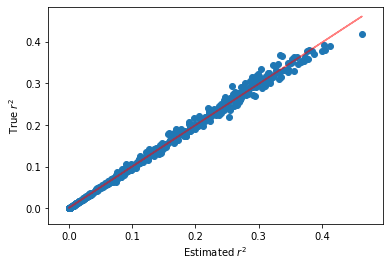

In [216]:
d = eval_pred(betas_thres,betas_t,x_t,D_mask)
r2_est = d['r2_est']
r2_true = d['r2_true']
plt.show()
plt.scatter(r2_est,r2_true)
ws = simp_lin_reg(r2_true, r2_est)
print (ws)
plt.plot(r2_est, ws[1]*r2_est + ws[0],color='r',alpha=0.5)
plt.xlabel(r'Estimated $r^2$')
plt.ylabel(r'True $r^2$')

[0.00257755 0.99512729]


Text(0, 0.5, 'True $r^2$')

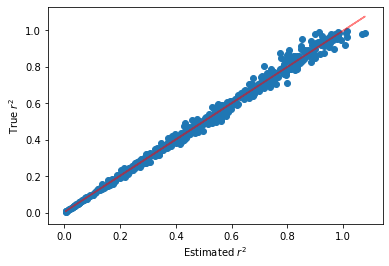

In [217]:
d = eval_pred(betas_true,betas_t,x_t,D_mask)
r2_est = d['r2_est']
r2_true = d['r2_true']
plt.show()
plt.scatter(r2_est,r2_true)
ws = simp_lin_reg(r2_true, r2_est)
print (ws)
plt.plot(r2_est, ws[1]*r2_est + ws[0],color='r',alpha=0.5)
plt.xlabel(r'Estimated $r^2$')
plt.ylabel(r'True $r^2$')

[0.00104115 0.99032666]


Text(0, 0.5, 'True $r^2$')

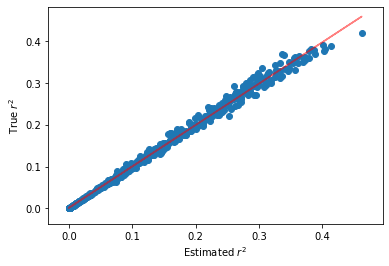

In [218]:
d = eval_pred(betas_thres,betas_t,x_t,D_mask_t)
r2_est = d['r2_est']
r2_true = d['r2_true']
plt.show()
plt.scatter(r2_est,r2_true)
ws = simp_lin_reg(r2_true, r2_est)
print (ws)
plt.plot(r2_est, ws[1]*r2_est + ws[0],color='r',alpha=0.5)
plt.xlabel(r'Estimated $r^2$')
plt.ylabel(r'True $r^2$')

[5.59448321e-17 1.00000000e+00]


Text(0, 0.5, 'True $r^2$')

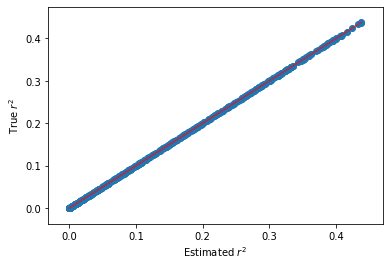

In [219]:
d = eval_pred(betas,betas_t,x_t,D_t)
r2_est = d['r2_est']
r2_true = d['r2_true']
plt.show()
plt.scatter(r2_est,r2_true)
ws = simp_lin_reg(r2_true, r2_est)
print (ws)
plt.plot(r2_est, ws[1]*r2_est + ws[0],color='r',alpha=0.5)
plt.xlabel(r'Estimated $r^2$')
plt.ylabel(r'True $r^2$')